# Download Dataset

In [ ]:
!gdown #link is hidden for privacy

In [2]:
!unzip /content/ai4mars-dataset-merged-0.1.zip

Streaming output truncated to the last 5000 lines.
  inflating: msl/labels/train/NLB_540247095EDR_F0610252NCAM00654M1.png  
  inflating: msl/labels/train/NLB_540247119EDR_F0610252NCAM00654M1.png  
  inflating: msl/labels/train/NLB_540247151EDR_F0610252NCAM00654M1.png  
  inflating: msl/labels/train/NLB_540247174EDR_F0610252NCAM00654M1.png  
  inflating: msl/labels/train/NLB_540247213EDR_F0610252NCAM00267M1.png  
  inflating: msl/labels/train/NLB_540247238EDR_F0610252NCAM00267M1.png  
  inflating: msl/labels/train/NLB_540247269EDR_F0610252NCAM00267M1.png  
  inflating: msl/labels/train/NLB_540247322EDR_F0610252NCAM00268M1.png  
  inflating: msl/labels/train/NLB_540247353EDR_F0610252NCAM00268M1.png  
  inflating: msl/labels/train/NLB_540247384EDR_F0610252NCAM00268M1.png  
  inflating: msl/labels/train/NLB_540247432EDR_F0610252NCAM00268M1.png  
  inflating: msl/labels/train/NLB_540247456EDR_F0610252NCAM00268M1.png  
  inflating: msl/labels/train/NLB_540247480EDR_F0610252NCAM00268M1.png  


# Data Preprocessing

## Preprocessing from Starter Notebook for AI4MARS

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

In [2]:
images = "/content/msl/images"
tr_lab = "/content/msl/labels/train"
edr = images + "/edr"
mxy = images + "/mxy" # not required
rng = images + "/rng-30m" # not required

In [3]:
edr_files = os.listdir(edr)
trlab_files = os.listdir(tr_lab)

X = []
y = []
c = 0

# preparing X and y
for lab_name in trlab_files:
    img_name = lab_name[:-4] + ".JPG"
    
    if img_name in edr_files:
        
        img_path = os.path.join(edr, img_name)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, dsize = (224, 224))
        
        lab_path = os.path.join(tr_lab, lab_name)
        lab_arr = cv2.imread(lab_path, 0)
        lab_arr = cv2.resize(lab_arr, (224, 224), interpolation = cv2.INTER_NEAREST)
        
        X.append(img_arr)
        y.append(lab_arr)
        
    c += 1
    if c >= 1000:
        break
        
X = np.asarray(X, dtype = np.float32) / 255.0
y = np.array(y, dtype = np.uint8)

# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)


# keeping integer values in labels will help us in segmentation task (UNet)
y[y==255] = 4

print(X.shape, y.shape)

(1000, 224, 224, 3) (1000, 224, 224)


## Display image example from Starter Code

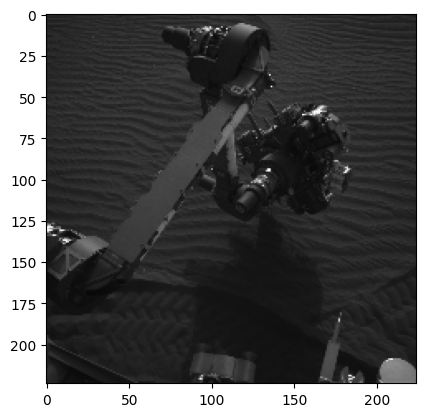

In [4]:
plt.imshow(X[250])

[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 2 ... 2 2 4]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]


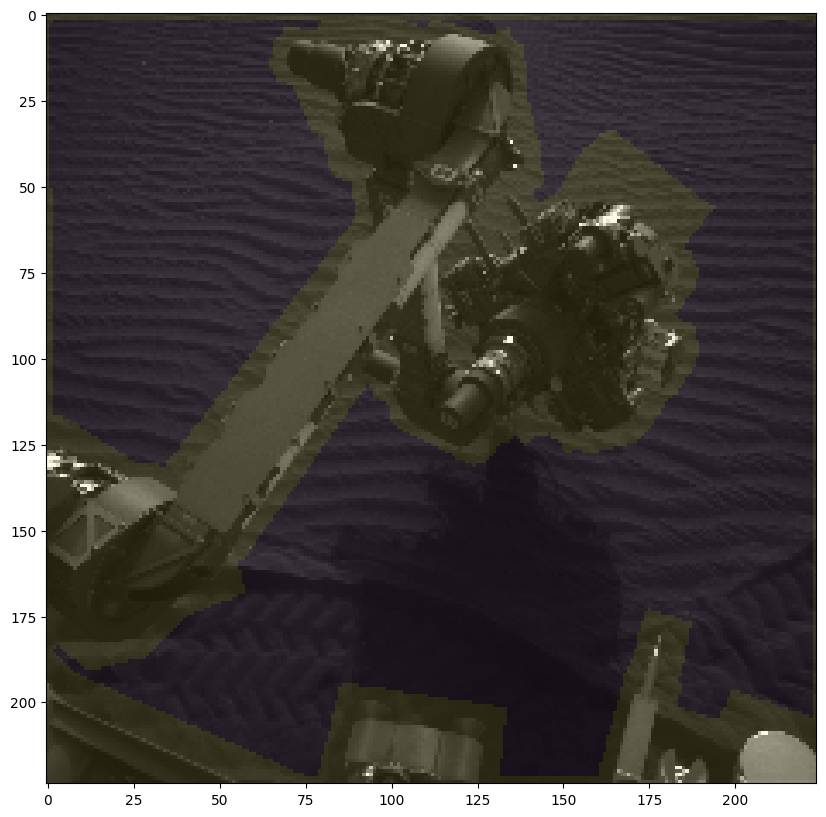

In [5]:
print(y[250])
plt.figure(figsize = (10, 10))

plt.imshow(X[250])
plt.imshow(y[250], alpha = 0.1)

plt.show()

## Getting the three test sets

In [6]:
# function to get test set from the said directory
def getTestData(testdir):
  testfiles = os.listdir(testdir)
  X_test = []
  y_test = []
  c = 0
  for lab_name in testfiles:
      img_name = lab_name[:-11] + ".JPG"
      
      if img_name in edr_files:
          
          img_path = os.path.join(edr, img_name)
          img_arr = cv2.imread(img_path)
          img_arr = cv2.resize(img_arr, dsize = (224, 224))
          
          lab_path = os.path.join(testdir, lab_name)
          lab_arr = cv2.imread(lab_path, 0)
          lab_arr = cv2.resize(lab_arr, (224, 224), interpolation = cv2.INTER_NEAREST)
          
          X_test.append(img_arr)
          y_test.append(lab_arr)
          
      c += 1
      if c >= 1000:
          break
          
  X_test = np.asarray(X_test, dtype = np.float32) / 255.0
  y_test = np.array(y_test, dtype = np.uint8)
  y_test[y_test==255] = 4

  return X_test, y_test
 

In [7]:
testdir1 = "/content/msl/labels/test/masked-gold-min1-100agree"
testdir2 = "/content/msl/labels/test/masked-gold-min2-100agree"
testdir3 = "/content/msl/labels/test/masked-gold-min3-100agree"

X_test1, y_test1 = getTestData(testdir1)

X_test2, y_test2 = getTestData(testdir2)

X_test3, y_test3 = getTestData(testdir3)


# Defining all Four MODELS

In [8]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dense, Input, Flatten, Reshape, Dropout, Lambda
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
import statistics
import seaborn as sns
import tensorflow as tf
import keras.backend as K
from segmentation_models import Unet


Segmentation Models: using `keras` framework.


1. Trying model 1 based on ResNet18 inspired from https://www.sciencedirect.com/topics/computer-science/residual-network#:~:text=ResNet18%20is%20a%2072%2Dlayer,convolutional%20layers%20to%20function%20efficiently.

In [10]:
def makeModel1():
  model = Sequential()
  model.add(Input((224,224,3)))

  model.add(Conv2D(32,3,padding="same",activation="relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32,3,padding="same",activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(64,3,padding="same",activation="relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64,3,padding="same",activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(128,3,padding="same",activation="relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(128,3,padding="same",activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(256,3,padding="same",activation="relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(256,3,padding="same",activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(1024, activation="relu"))
  model.add(Dropout(0.5))

  model.add(Dense(512,activation="relu"))
  model.add(Dropout(0.5))

  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=64, activation='relu'))
  model.add(Dense(units=224*224*5, activation='softmax'))
  model.add(Reshape((224, 224, 5)))
  
  return model

2. Model 2 is a modified untrained U-Net model taken from https://www.machinelearningnuggets.com/image-segmentation-with-u-net-define-u-net-model-from-scratch-in-keras-and-tensorflow/

In [11]:
#U-net model taken from https://www.machinelearningnuggets.com/image-segmentation-with-u-net-define-u-net-model-from-scratch-in-keras-and-tensorflow/
# Modified slightly to comply with dataset dimensions
def makeModel2():
  num_classes = 5

  inputs = tf.keras.layers.Input((224, 224, 3))

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  b1 = tf.keras.layers.BatchNormalization()(c1)
  r1 = tf.keras.layers.ReLU()(b1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  b2 = tf.keras.layers.BatchNormalization()(c2)
  r2 = tf.keras.layers.ReLU()(b2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
  
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  b3 = tf.keras.layers.BatchNormalization()(c3)
  r3 = tf.keras.layers.ReLU()(b3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
  
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  b4 = tf.keras.layers.BatchNormalization()(c4)
  r4 = tf.keras.layers.ReLU()(b4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
  
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  b5 = tf.keras.layers.BatchNormalization()(c5)
  r5 = tf.keras.layers.ReLU()(b5)
  c5 = tf.keras.layers.Dropout(0.3)(r5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  u6 = tf.keras.layers.BatchNormalization()(u6)
  u6 = tf.keras.layers.ReLU()(u6)

  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  u7 = tf.keras.layers.BatchNormalization()(u7)
  u7 = tf.keras.layers.ReLU()(u7)

  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  u8 = tf.keras.layers.BatchNormalization()(u8)
  u8 = tf.keras.layers.ReLU()(u8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  u9 = tf.keras.layers.BatchNormalization()(u9)
  u9 = tf.keras.layers.ReLU()(u9)

  
  outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  return model

3. This third model is also using U-Net architecture. However, it has pre-trained weights and a backbone using ResNet34. Model tutorial link from https://segmentation-models.readthedocs.io/en/latest/tutorial.html#:~:text=Segmentation%20models%20is%20python%20library,class%20segmentation%20(including%20legendary%20Unet)

In [12]:
def makeModel3():
  model = Unet('resnet34', input_shape=(224, 224, 3), encoder_weights='imagenet', classes = 5)
  return model

4. Same as the third model but this time we only use pre-trained weights and no backbone.

In [13]:
def makeModel4():
  model = Unet(input_shape=(224, 224, 3), classes = 5, encoder_weights='imagenet', activation='sigmoid')
  return model

# Model Choice Decision

## Create Helper Functions for K-fold Cross Validation and Performance Measurement

Documentation for the k-fold cross validation function: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [14]:
# defining k-fold (k = 6)
kf = KFold(n_splits=6, shuffle=True)

In [15]:
# categorize train data
y1 = to_categorical(y, num_classes=5)

We are training on 30 epochs for each fold to check which model has the best validation accuracy

In [16]:
#function to fit model and validate it
def fitModelAndValidate(model1):
  validation_performance = []
  validation_loss = []
  for fold, (train_indices, val_indices) in enumerate(kf.split(X)):
    # Assign new train and val
    X_train, y_train = X[train_indices], y1[train_indices]
    X_val, y_val = X[val_indices], y1[val_indices]
    
    print("\n")
    print("==============================================================================================================")
    print("\n")
    print("Training fold", fold)
    print("Shape of training set: ", X_train.shape)
    print("Shape of validation set: ", X_val.shape)
    
    #reset model at each fold 
    model = model1()
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
   
    h = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))
    
    print("Computing final validation accuracy")
    vali_loss, vali_accuracy = model.evaluate(X_val, y_val)
    validation_performance.append(vali_accuracy)
    validation_loss.append(vali_loss)

  return validation_performance, validation_loss

In [17]:
#helper function to print out performance of each model
def averageAndVariance(nb, performance):
  mean = sum(performance) / len(performance)
  variance = s(performance)

  print("Average Validation Accuracy of Model ", nb, ": ", mean)
  print("Validation Variance of Model ",nb, ": ", variance)

## Fit and Evaluate Model 1

In [18]:
# Evaluating + Fitting Model1(ResNet18 inspired architecture)
validation_performance1, validation_loss1 = fitModelAndValidate(makeModel1)






Training fold 0
Shape of training set:  (833, 224, 224, 3)
Shape of validation set:  (167, 224, 224, 3)
Epoch 1/30
27/27 [==============================] - 23s 100ms/step - loss: 1.3151 - accuracy: 0.4193 - val_loss: 1.4690 - val_accuracy: 0.3929
Epoch 2/30
27/27 [==============================] - 1s 52ms/step - loss: 1.2864 - accuracy: 0.4405 - val_loss: 1.3708 - val_accuracy: 0.4501
Epoch 3/30
27/27 [==============================] - 1s 53ms/step - loss: 1.2624 - accuracy: 0.4449 - val_loss: 1.3985 - val_accuracy: 0.4476
Epoch 4/30
27/27 [==============================] - 1s 54ms/step - loss: 1.2430 - accuracy: 0.4620 - val_loss: 1.4259 - val_accuracy: 0.3526
Epoch 5/30
27/27 [==============================] - 1s 53ms/step - loss: 1.2546 - accuracy: 0.4537 - val_loss: 1.3779 - val_accuracy: 0.4308
Epoch 6/30
27/27 [==============================] - 1s 54ms/step - loss: 1.2369 - accuracy: 0.4597 - val_loss: 1.3647 - val_accuracy: 0.3290
Epoch 7/30
27/27 [==========================

## Fit and Evaluate Model 2

In [19]:
# Evaluating + Fitting Model2(U-NET inspired architecture)
validation_performance2, validation_loss2 = fitModelAndValidate(makeModel2)





Training fold 0
Shape of training set:  (833, 224, 224, 3)
Shape of validation set:  (167, 224, 224, 3)
Epoch 1/30
27/27 [==============================] - 14s 119ms/step - loss: 1.4305 - accuracy: 0.4462 - val_loss: 1.5920 - val_accuracy: 0.4079
Epoch 2/30
27/27 [==============================] - 2s 58ms/step - loss: 1.1641 - accuracy: 0.5058 - val_loss: 1.4709 - val_accuracy: 0.3977
Epoch 3/30
27/27 [==============================] - 2s 57ms/step - loss: 1.0770 - accuracy: 0.5460 - val_loss: 1.3145 - val_accuracy: 0.4249
Epoch 4/30
27/27 [==============================] - 2s 58ms/step - loss: 1.0073 - accuracy: 0.5969 - val_loss: 1.3430 - val_accuracy: 0.3519
Epoch 5/30
27/27 [==============================] - 2s 58ms/step - loss: 0.9354 - accuracy: 0.6477 - val_loss: 1.2899 - val_accuracy: 0.3864
Epoch 6/30
27/27 [==============================] - 2s 58ms/step - loss: 0.8796 - accuracy: 0.6762 - val_loss: 1.3417 - val_accuracy: 0.3480
Epoch 7/30
27/27 [==========================

## Fit and Evaluate Model 3

In [20]:
# Evaluating + Fitting Model3(U-NET advanced architecture with ResNet34 Backbone)
validation_performance3, validation_loss3 = fitModelAndValidate(makeModel3)





Training fold 0
Shape of training set:  (833, 224, 224, 3)
Shape of validation set:  (167, 224, 224, 3)
85521592/85521592 [==============================] - 1s 0us/step
Epoch 1/30
27/27 [==============================] - 33s 225ms/step - loss: 0.9940 - accuracy: 0.6477 - val_loss: 3.3439 - val_accuracy: 0.4013
Epoch 2/30
27/27 [==============================] - 2s 89ms/step - loss: 0.6777 - accuracy: 0.7603 - val_loss: 3.8499 - val_accuracy: 0.1114
Epoch 3/30
27/27 [==============================] - 2s 89ms/step - loss: 0.5921 - accuracy: 0.7848 - val_loss: 76.6900 - val_accuracy: 0.0787
Epoch 4/30
27/27 [==============================] - 2s 90ms/step - loss: 0.5314 - accuracy: 0.8027 - val_loss: 4.8519 - val_accuracy: 0.1605
Epoch 5/30
27/27 [==============================] - 2s 89ms/step - loss: 0.5459 - accuracy: 0.7982 - val_loss: 449.4244 - val_accuracy: 0.0712
Epoch 6/30
27/27 [==============================] - 2s 88ms/step - loss: 0.5610 - accuracy: 0.7941 - val_loss: 5.1583

## Fit and Evaluate Model 4

In [21]:
validation_performance4, validation_loss4 = fitModelAndValidate(makeModel4)





Training fold 0
Shape of training set:  (833, 224, 224, 3)
Shape of validation set:  (167, 224, 224, 3)
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
27/27 [==============================] - 20s 211ms/step - loss: 1.1510 - accuracy: 0.5638 - val_loss: 151.2937 - val_accuracy: 0.4445
Epoch 2/30
27/27 [==============================] - 3s 109ms/step - loss: 0.7982 - accuracy: 0.6967 - val_loss: 24.5891 - val_accuracy: 0.4446
Epoch 3/30
27/27 [==============================] - 3s 109ms/step - loss: 0.7483 - accuracy: 0.7107 - val_loss: 6.3367 - val_accuracy: 0.4450
Epoch 4/30
27/27 [==============================] - 3s 108ms/step - loss: 0.7169 - accuracy: 0.7194 - val_loss: 2.2035 - val_accuracy: 0.4981
Epoch 5/30
27/27 [==============================] - 3s 110ms/step - loss: 0.7019 - accuracy: 0.7258 - val_loss: 5.0536 - val_accuracy: 0.3036
Epoch 6/30
27/27 [==============================] - 3s 110ms/step - loss: 0.6808 - accuracy: 0.7339 - val_loss: 1

## Comparing the four Models

Graph for performance

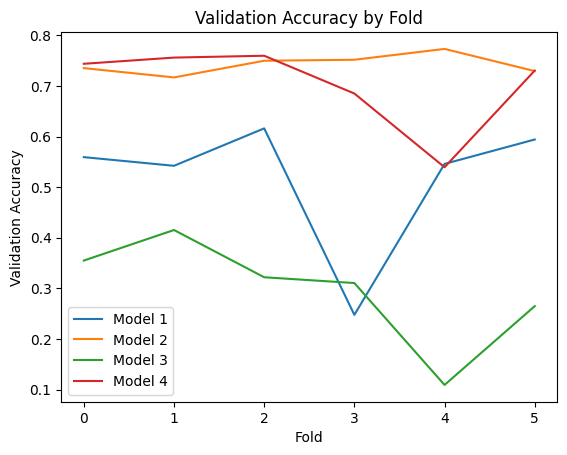

In [22]:
#plots graph for validation accuracy by Fold
plt.plot([0,1,2,3,4,5], validation_performance1, label='Model 1')
plt.plot([0,1,2,3,4,5], validation_performance2, label='Model 2')
plt.plot([0,1,2,3,4,5], validation_performance3, label='Model 3')
plt.plot([0,1,2,3,4,5], validation_performance4, label='Model 4')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy by Fold')
plt.legend()
plt.show()

Graph for loss

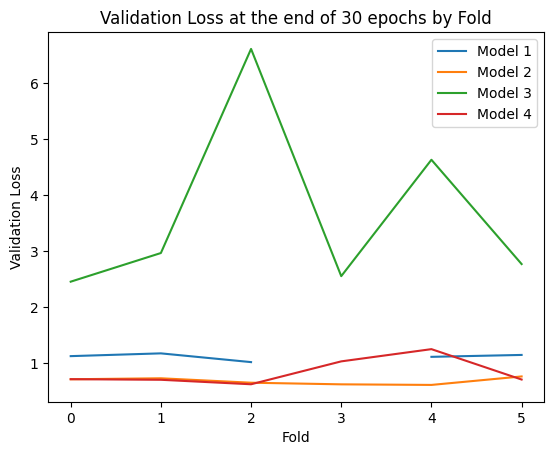

In [23]:
#plots graph for validation loss
plt.plot([0,1,2,3,4,5], validation_loss1, label='Model 1')
plt.plot([0,1,2,3,4,5], validation_loss2, label='Model 2')
plt.plot([0,1,2,3,4,5], validation_loss3, label='Model 3')
plt.plot([0,1,2,3,4,5], validation_loss4, label='Model 4')
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.title('Validation Loss at the end of 30 epochs by Fold')
plt.legend()
plt.show()

In [24]:
#Compute and print average and variance of each model
averageAndVariance(1, validation_performance1)
print("\n")
averageAndVariance(2, validation_performance2)
print("\n")
averageAndVariance(3, validation_performance3)
print("\n")
averageAndVariance(4, validation_performance4)

Average Validation Accuracy of Model  1 :  0.5176292931040128
Validation Variance of Model  1 :  0.018318919199890475


Average Validation Accuracy of Model  2 :  0.7427704632282257
Validation Variance of Model  2 :  0.0003922373193557149


Average Validation Accuracy of Model  3 :  0.29617753997445107
Validation Variance of Model  3 :  0.010894426353871361


Average Validation Accuracy of Model  4 :  0.7024562160174052
Validation Variance of Model  4 :  0.007109507479095593


**Clearly, we can see that Model 2 has the best performance for accuracy and has the lowest variance.**

# Final Model (Model 2)

In [26]:
# Showing the model layers
model = makeModel2()
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 224, 224, 16  448         ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_54 (Dropout)           (None, 224, 224, 16  0           ['conv2d_114[0][0]']             
                                )                                                          

## Training the Chosen Model using 150 epochs

In [27]:
# compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#categorize train data
y1 = to_categorical(y, num_classes=5)

# fit model
h = model.fit(X, y1, batch_size=32, epochs=150)


Epoch 1/150
32/32 [==============================] - 11s 83ms/step - loss: 1.4223 - accuracy: 0.4132
Epoch 2/150
32/32 [==============================] - 2s 53ms/step - loss: 1.1169 - accuracy: 0.5581
Epoch 3/150
32/32 [==============================] - 2s 53ms/step - loss: 0.9759 - accuracy: 0.6336
Epoch 4/150
32/32 [==============================] - 2s 53ms/step - loss: 0.8677 - accuracy: 0.6817
Epoch 5/150
32/32 [==============================] - 2s 53ms/step - loss: 0.8003 - accuracy: 0.7057
Epoch 6/150
32/32 [==============================] - 2s 54ms/step - loss: 0.7578 - accuracy: 0.7201
Epoch 7/150
32/32 [==============================] - 2s 53ms/step - loss: 0.7314 - accuracy: 0.7297
Epoch 8/150
32/32 [==============================] - 2s 53ms/step - loss: 0.7155 - accuracy: 0.7352
Epoch 9/150
32/32 [==============================] - 2s 53ms/step - loss: 0.6965 - accuracy: 0.7411
Epoch 10/150
32/32 [==============================] - 2s 53ms/step - loss: 0.6563 - accuracy: 0.755

# Results

## Model Performance on test sets

Test Set 1



In [29]:
y_test11 = to_categorical(y_test1, num_classes=5)

test_loss1, test_accuracy1 = model.evaluate(X_test1, y_test11)
print('Test loss:', test_loss1)
print('Test accuracy on Set 1:', test_accuracy1)

11/11 [==============================] - 0s 20ms/step - loss: 0.9882 - accuracy: 0.7732
Test loss: 0.9882168173789978
Test accuracy on Set 1: 0.7731566429138184


Test Set 2

In [30]:
y_test21 = to_categorical(y_test2, num_classes=5)

test_loss2, test_accuracy2 = model.evaluate(X_test2, y_test21)
print('Test loss:', test_loss2)
print('Test accuracy on Set 2:', test_accuracy2)

11/11 [==============================] - 0s 19ms/step - loss: 1.0090 - accuracy: 0.7560
Test loss: 1.009019136428833
Test accuracy on Set 2: 0.7560403347015381


Test Set 3

In [31]:
y_test31 = to_categorical(y_test3, num_classes=5)

test_loss3, test_accuracy3 = model.evaluate(X_test3, y_test31)
print('Test loss:', test_loss3)
print('Test accuracy on Set 3:', test_accuracy3)

11/11 [==============================] - 0s 19ms/step - loss: 1.3375 - accuracy: 0.6909
Test loss: 1.3375204801559448
Test accuracy on Set 3: 0.6909292340278625


In [32]:
print((test_accuracy1+test_accuracy2+test_accuracy3)/3)

0.7400420705477396


**Overall our best Test Accuracy was 75.07% even if it is currently at 74%**

## Confusion Matrices

In [33]:
# Define the labels
labels = ["Soil", "Bedrock", "Sand", "BigRock", "Null"]

Test Set 1

11/11 [==============================] - 0s 10ms/step


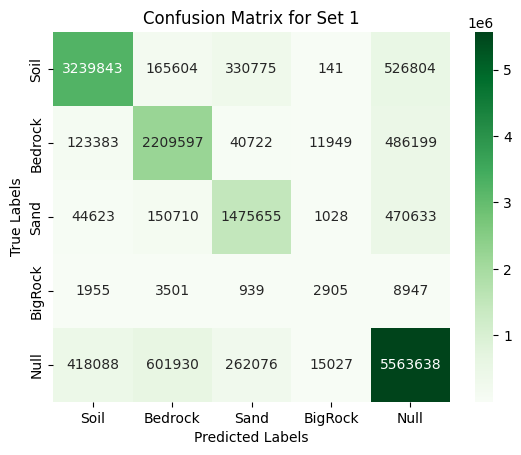

In [34]:
y_pred = model.predict(X_test1)
y_test12 = y_test1.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test12, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 1")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Test set 2

11/11 [==============================] - 0s 10ms/step


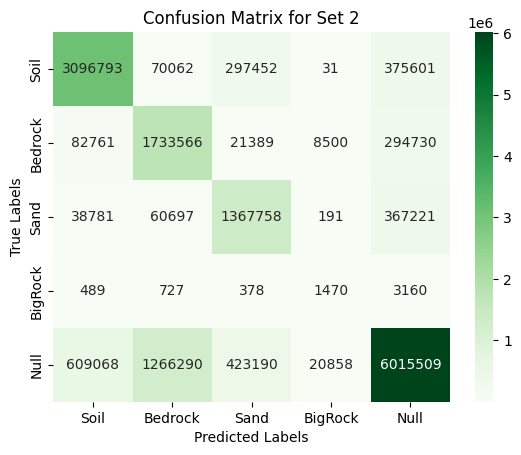

In [35]:
y_pred = model.predict(X_test2)
y_test22 = y_test2.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test22, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 2")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Test Set 3

11/11 [==============================] - 0s 10ms/step


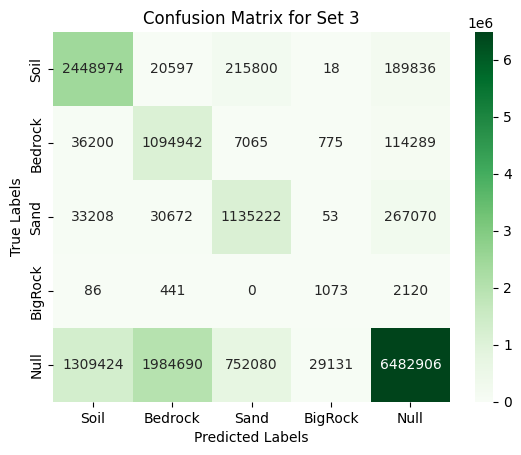

In [36]:
y_pred = model.predict(X_test3)
y_test32 = y_test3.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test32, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 3")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Graphical Representations

Prediction Output Segmentation Images

11/11 [==============================] - 0s 10ms/step


<ipython-input-37-c1b0c6fd0c37>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)


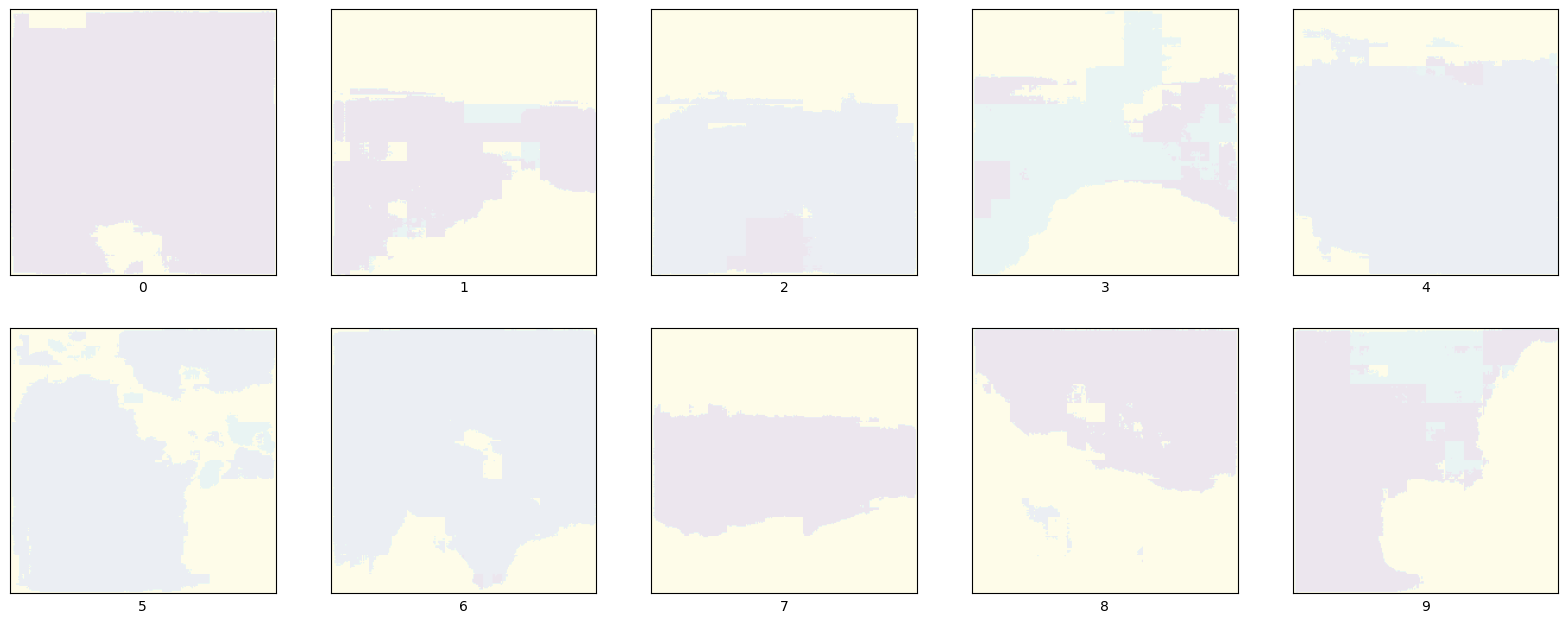

In [37]:
y_pred = model.predict(X_test1)
predicted_classes = np.argmax(y_pred, axis=-1)

plt.figure(figsize=(20,20))
plt.title("Prediction Output Segmentation")
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predicted_classes[i], alpha = 0.1)
    plt.xlabel(i)
plt.show()

Real Output Segmentation Images

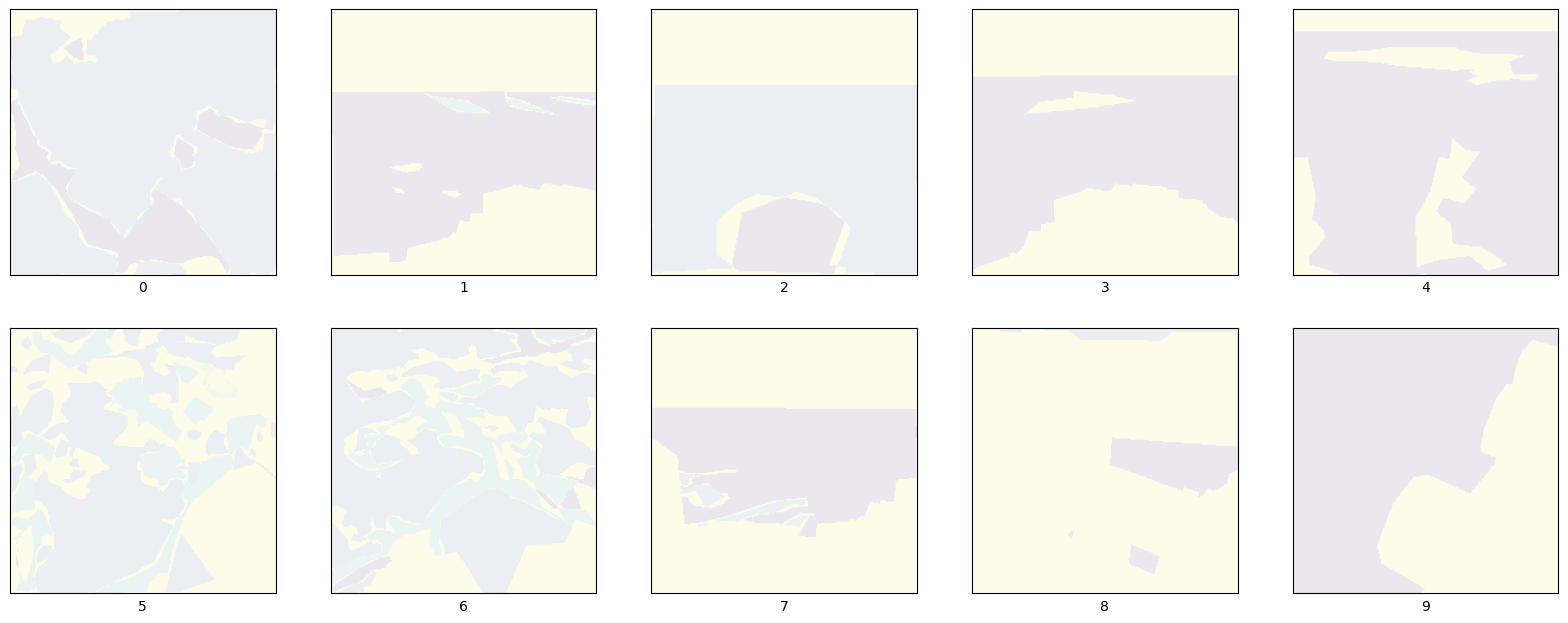

In [38]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(y_test1[i], alpha = 0.1)
    plt.xlabel(i)
    
plt.show()

# Experiment on other models (Advanced Objective)

## Model 1

In [39]:
# create model
model = makeModel1()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#categorize train data
y1 = to_categorical(y, num_classes=5)

# fit model
h = model.fit(X, y1, batch_size=32, epochs=150)

Epoch 1/150
32/32 [==============================] - 10s 68ms/step - loss: 1.3034 - accuracy: 0.4245
Epoch 2/150
32/32 [==============================] - 2s 48ms/step - loss: 1.2746 - accuracy: 0.4347
Epoch 3/150
32/32 [==============================] - 2s 48ms/step - loss: 1.2542 - accuracy: 0.4482
Epoch 4/150
32/32 [==============================] - 2s 48ms/step - loss: 1.2430 - accuracy: 0.4613
Epoch 5/150
32/32 [==============================] - 2s 48ms/step - loss: 1.2185 - accuracy: 0.4791
Epoch 6/150
32/32 [==============================] - 2s 49ms/step - loss: 1.2297 - accuracy: 0.4677
Epoch 7/150
32/32 [==============================] - 2s 48ms/step - loss: 1.2136 - accuracy: 0.4769
Epoch 8/150
32/32 [==============================] - 2s 48ms/step - loss: 1.1807 - accuracy: 0.4952
Epoch 9/150
32/32 [==============================] - 2s 47ms/step - loss: 1.1868 - accuracy: 0.5080
Epoch 10/150
32/32 [==============================] - 2s 48ms/step - loss: 1.1352 - accuracy: 0.525

### Model Performance on test sets

Test Set 1



In [40]:
y_test11 = to_categorical(y_test1, num_classes=5)

test_loss1, test_accuracy1 = model.evaluate(X_test1, y_test11)
print('Test loss:', test_loss1)
print('Test accuracy on Set 1:', test_accuracy1)

11/11 [==============================] - 1s 21ms/step - loss: nan - accuracy: 0.2639
Test loss: nan
Test accuracy on Set 1: 0.2638641893863678


Test Set 2

In [41]:
y_test21 = to_categorical(y_test2, num_classes=5)

test_loss2, test_accuracy2 = model.evaluate(X_test2, y_test21)
print('Test loss:', test_loss2)
print('Test accuracy on Set 2:', test_accuracy2)

11/11 [==============================] - 0s 19ms/step - loss: nan - accuracy: 0.2377
Test loss: nan
Test accuracy on Set 2: 0.2376689314842224


Test Set 3

In [42]:
y_test31 = to_categorical(y_test3, num_classes=5)

test_loss3, test_accuracy3 = model.evaluate(X_test3, y_test31)
print('Test loss:', test_loss3)
print('Test accuracy on Set 3:', test_accuracy3)

11/11 [==============================] - 0s 18ms/step - loss: nan - accuracy: 0.1780
Test loss: nan
Test accuracy on Set 3: 0.17795899510383606


In [43]:
print((test_accuracy1+test_accuracy2+test_accuracy3)/3)

0.22649737199147543


### Confusion Matrices

In [44]:
# Define the labels
labels = ["Soil", "Bedrock", "Sand", "BigRock", "Null"]

Test Set 1

11/11 [==============================] - 0s 12ms/step


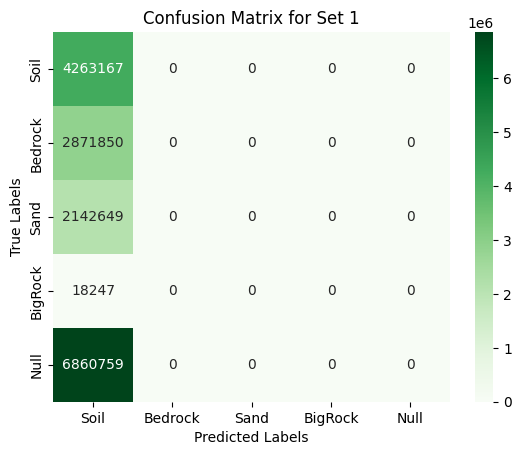

In [45]:
y_pred = model.predict(X_test1)
y_test12 = y_test1.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test12, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 1")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Test set 2

11/11 [==============================] - 0s 13ms/step


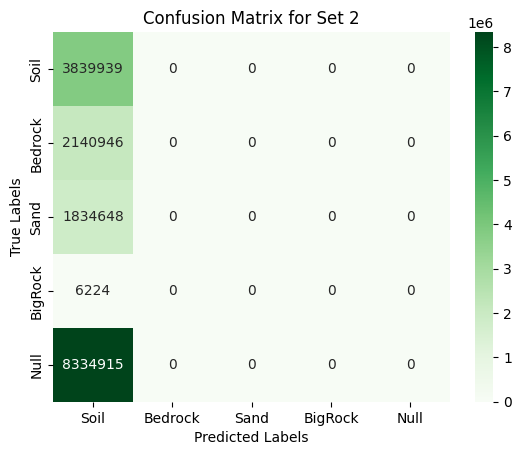

In [46]:
y_pred = model.predict(X_test2)
y_test22 = y_test2.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test22, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 2")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Test Set 3

11/11 [==============================] - 0s 13ms/step


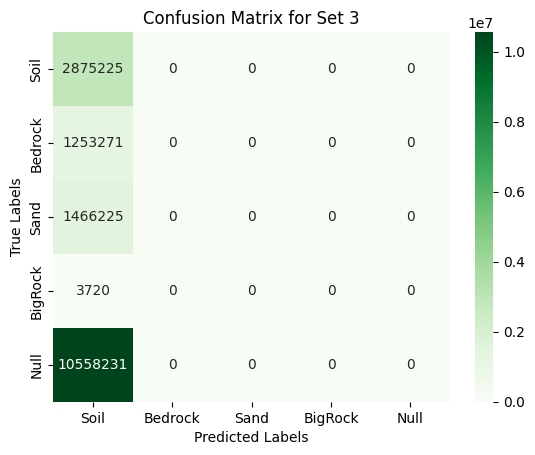

In [47]:
y_pred = model.predict(X_test3)
y_test32 = y_test3.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test32, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 3")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Graphical Representations

Prediction Output Segmentation Images

11/11 [==============================] - 0s 13ms/step


<ipython-input-48-c1b0c6fd0c37>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)


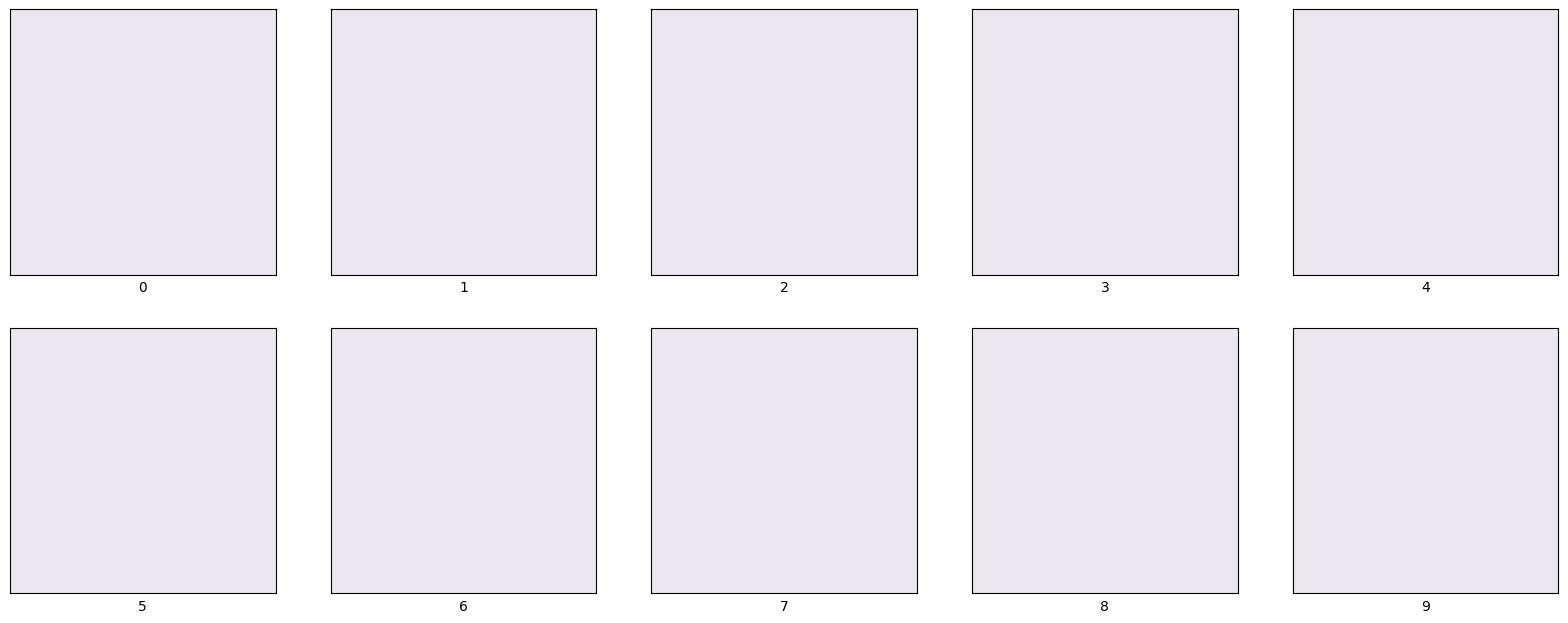

In [48]:
y_pred = model.predict(X_test1)
predicted_classes = np.argmax(y_pred, axis=-1)

plt.figure(figsize=(20,20))
plt.title("Prediction Output Segmentation")
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predicted_classes[i], alpha = 0.1)
    plt.xlabel(i)
plt.show()

Real Output Segmentation Images

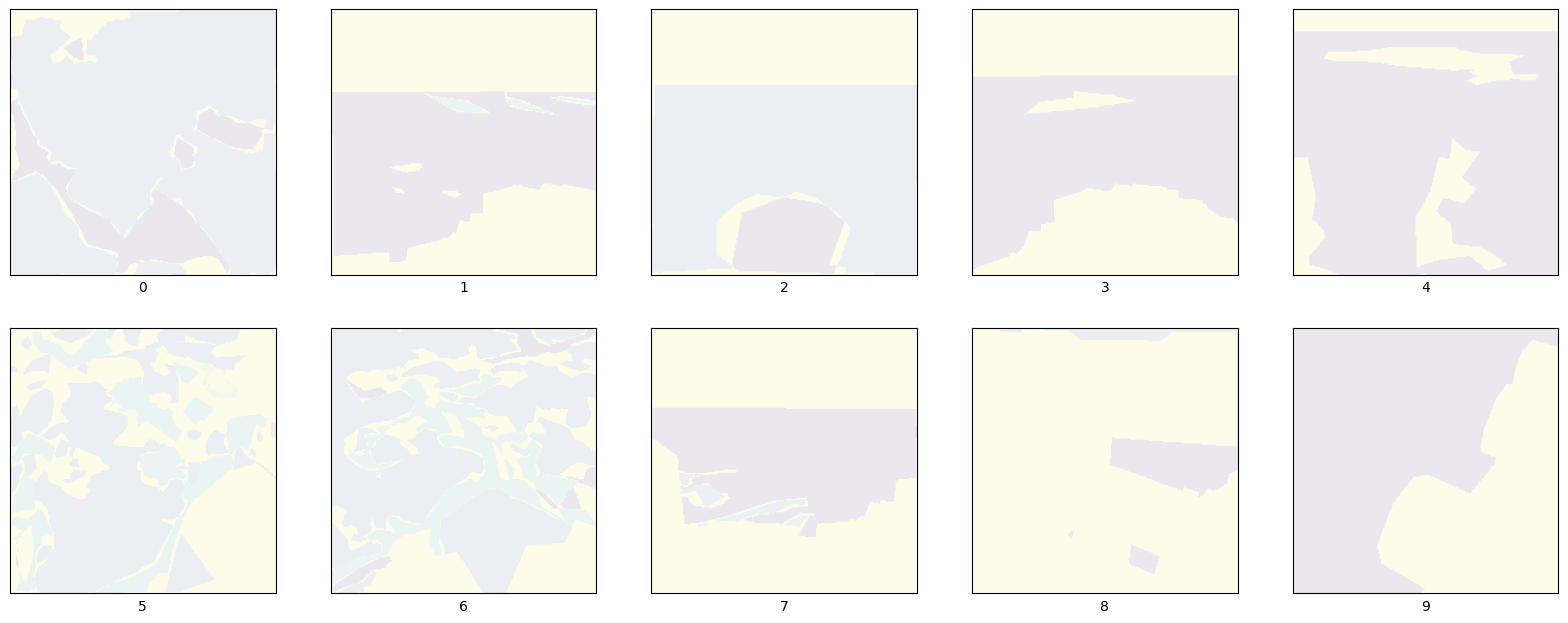

In [49]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(y_test1[i], alpha = 0.1)
    plt.xlabel(i)
    
plt.show()

## Model 3

In [50]:
# create model
model = makeModel3()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#categorize train data
y1 = to_categorical(y, num_classes=5)

# fit model
h = model.fit(X, y1, batch_size=32, epochs=150)

Epoch 1/150
32/32 [==============================] - 28s 130ms/step - loss: 0.8912 - accuracy: 0.6902
Epoch 2/150
32/32 [==============================] - 3s 83ms/step - loss: 0.6208 - accuracy: 0.7735
Epoch 3/150
32/32 [==============================] - 3s 83ms/step - loss: 0.5516 - accuracy: 0.7931
Epoch 4/150
32/32 [==============================] - 3s 82ms/step - loss: 0.5079 - accuracy: 0.8070
Epoch 5/150
32/32 [==============================] - 3s 82ms/step - loss: 0.4796 - accuracy: 0.8198
Epoch 6/150
32/32 [==============================] - 3s 82ms/step - loss: 0.5579 - accuracy: 0.7873
Epoch 7/150
32/32 [==============================] - 3s 84ms/step - loss: 0.4777 - accuracy: 0.8181
Epoch 8/150
32/32 [==============================] - 3s 83ms/step - loss: 0.4375 - accuracy: 0.8347
Epoch 9/150
32/32 [==============================] - 3s 83ms/step - loss: 0.4285 - accuracy: 0.8349
Epoch 10/150
32/32 [==============================] - 3s 82ms/step - loss: 0.3910 - accuracy: 0.85

### Model Performance on test sets

Test Set 1



In [51]:
y_test11 = to_categorical(y_test1, num_classes=5)

test_loss1, test_accuracy1 = model.evaluate(X_test1, y_test11)
print('Test loss:', test_loss1)
print('Test accuracy on Set 1:', test_accuracy1)

11/11 [==============================] - 2s 64ms/step - loss: 0.8159 - accuracy: 0.8136
Test loss: 0.8159388899803162
Test accuracy on Set 1: 0.8136231899261475


Test Set 2

In [52]:
y_test21 = to_categorical(y_test2, num_classes=5)

test_loss2, test_accuracy2 = model.evaluate(X_test2, y_test21)
print('Test loss:', test_loss2)
print('Test accuracy on Set 2:', test_accuracy2)

11/11 [==============================] - 0s 27ms/step - loss: 0.8802 - accuracy: 0.7909
Test loss: 0.880180299282074
Test accuracy on Set 2: 0.790922999382019


Test Set 3

In [53]:
y_test31 = to_categorical(y_test3, num_classes=5)

test_loss3, test_accuracy3 = model.evaluate(X_test3, y_test31)
print('Test loss:', test_loss3)
print('Test accuracy on Set 3:', test_accuracy3)

11/11 [==============================] - 0s 27ms/step - loss: 1.3207 - accuracy: 0.7077
Test loss: 1.3207117319107056
Test accuracy on Set 3: 0.707711398601532


In [54]:
print((test_accuracy1+test_accuracy2+test_accuracy3)/3)

0.7707525293032328


### Confusion Matrices

In [55]:
# Define the labels
labels = ["Soil", "Bedrock", "Sand", "BigRock", "Null"]

Test Set 1

11/11 [==============================] - 1s 18ms/step


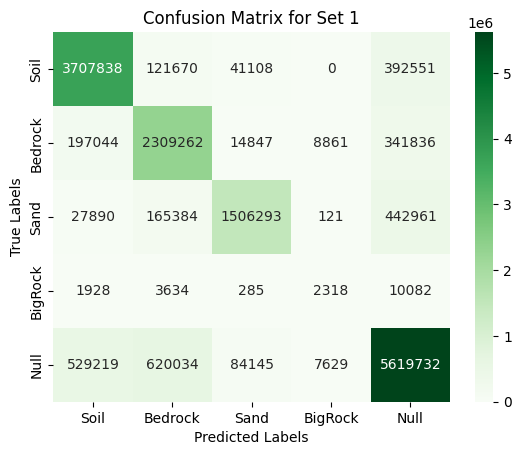

In [56]:
y_pred = model.predict(X_test1)
y_test12 = y_test1.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test12, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 1")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Test set 2

11/11 [==============================] - 0s 19ms/step


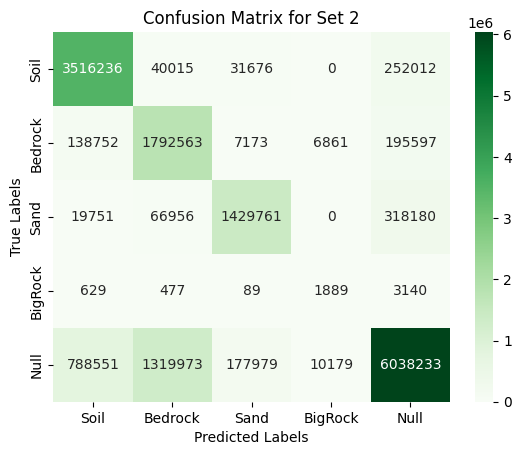

In [57]:
y_pred = model.predict(X_test2)
y_test22 = y_test2.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test22, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 2")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Test Set 3

11/11 [==============================] - 0s 21ms/step


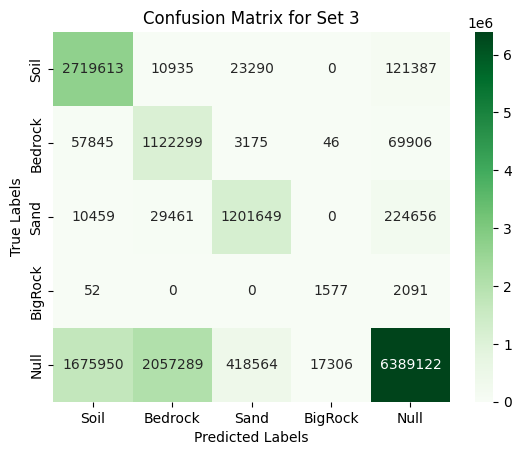

In [58]:
y_pred = model.predict(X_test3)
y_test32 = y_test3.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test32, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 3")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Graphical Representations

Prediction Output Segmentation Images

11/11 [==============================] - 0s 19ms/step


<ipython-input-59-c1b0c6fd0c37>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)


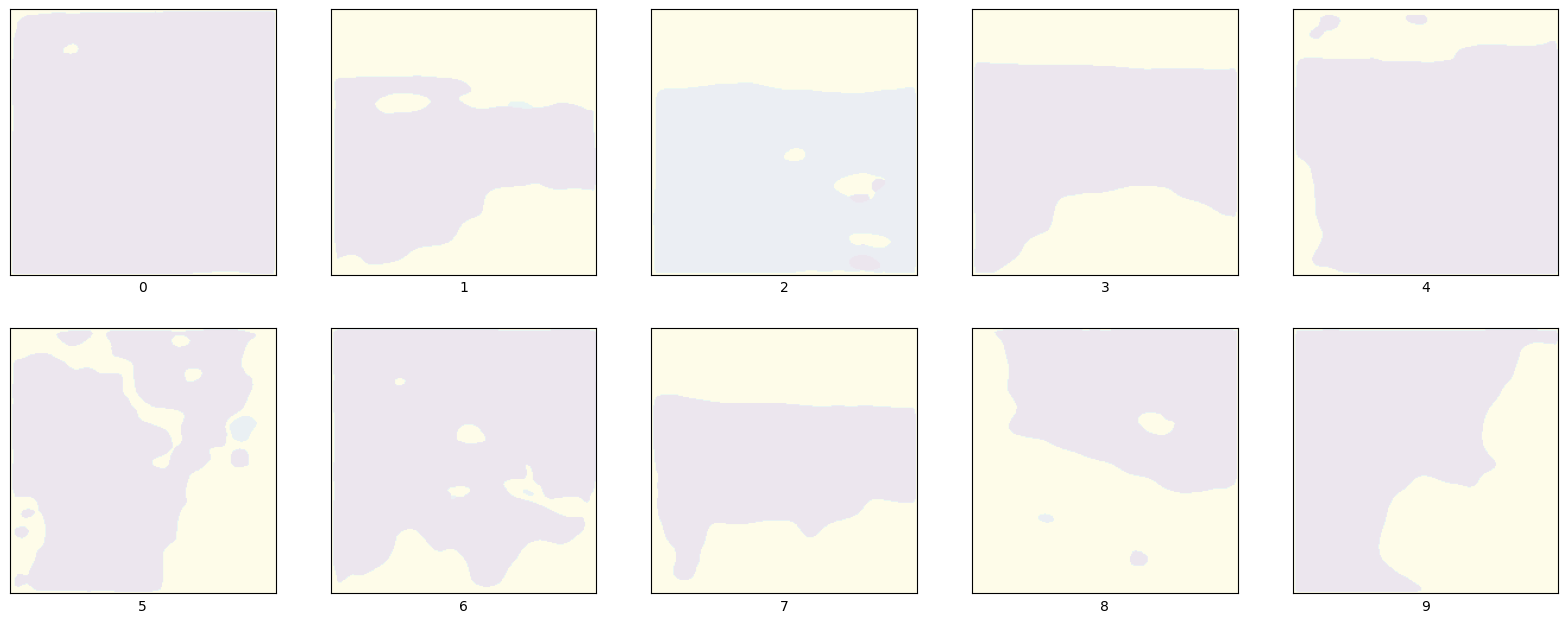

In [59]:
y_pred = model.predict(X_test1)
predicted_classes = np.argmax(y_pred, axis=-1)

plt.figure(figsize=(20,20))
plt.title("Prediction Output Segmentation")
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predicted_classes[i], alpha = 0.1)
    plt.xlabel(i)
plt.show()

Real Output Segmentation Images

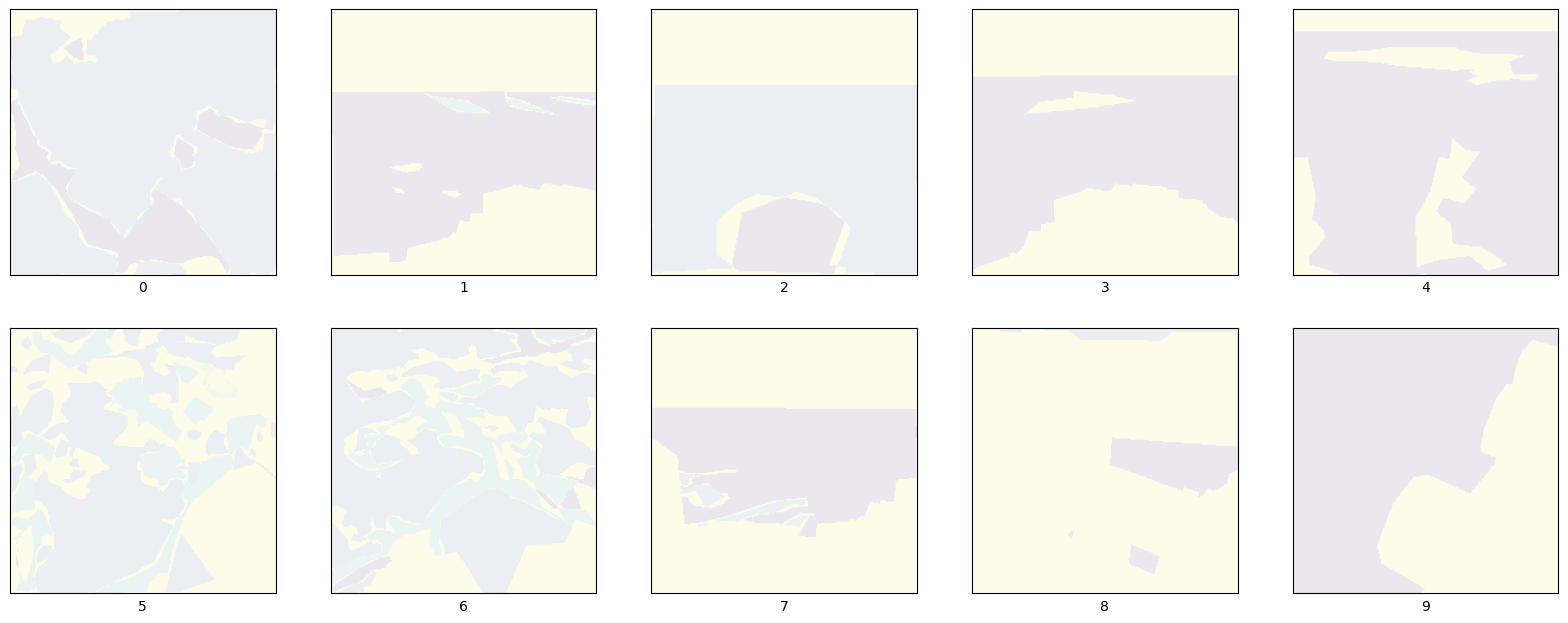

In [60]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(y_test1[i], alpha = 0.1)
    plt.xlabel(i)
    
plt.show()

## Model 4

In [61]:
# create model
model = makeModel4()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#categorize train data
y1 = to_categorical(y, num_classes=5)

# fit model
h = model.fit(X, y1, batch_size=32, epochs=150)

Epoch 1/150
32/32 [==============================] - 15s 148ms/step - loss: 1.2055 - accuracy: 0.5267
Epoch 2/150
32/32 [==============================] - 3s 101ms/step - loss: 0.8251 - accuracy: 0.6821
Epoch 3/150
32/32 [==============================] - 3s 101ms/step - loss: 0.7621 - accuracy: 0.7055
Epoch 4/150
32/32 [==============================] - 3s 101ms/step - loss: 0.7482 - accuracy: 0.7101
Epoch 5/150
32/32 [==============================] - 3s 100ms/step - loss: 0.7008 - accuracy: 0.7318
Epoch 6/150
32/32 [==============================] - 3s 101ms/step - loss: 0.6672 - accuracy: 0.7441
Epoch 7/150
32/32 [==============================] - 3s 101ms/step - loss: 0.6556 - accuracy: 0.7470
Epoch 8/150
32/32 [==============================] - 3s 100ms/step - loss: 0.6376 - accuracy: 0.7528
Epoch 9/150
32/32 [==============================] - 3s 101ms/step - loss: 0.6217 - accuracy: 0.7593
Epoch 10/150
32/32 [==============================] - 3s 100ms/step - loss: 0.6073 - accur

### Model Performance on test sets

Test Set 1



In [62]:
y_test11 = to_categorical(y_test1, num_classes=5)

test_loss1, test_accuracy1 = model.evaluate(X_test1, y_test11)
print('Test loss:', test_loss1)
print('Test accuracy on Set 1:', test_accuracy1)

11/11 [==============================] - 1s 50ms/step - loss: 0.9859 - accuracy: 0.7919
Test loss: 0.9859204888343811
Test accuracy on Set 1: 0.7918822169303894


Test Set 2

In [63]:
y_test21 = to_categorical(y_test2, num_classes=5)

test_loss2, test_accuracy2 = model.evaluate(X_test2, y_test21)
print('Test loss:', test_loss2)
print('Test accuracy on Set 2:', test_accuracy2)

11/11 [==============================] - 0s 36ms/step - loss: 0.8728 - accuracy: 0.7913
Test loss: 0.8727556467056274
Test accuracy on Set 2: 0.7913332581520081


Test Set 3

In [64]:
y_test31 = to_categorical(y_test3, num_classes=5)

test_loss3, test_accuracy3 = model.evaluate(X_test3, y_test31)
print('Test loss:', test_loss3)
print('Test accuracy on Set 3:', test_accuracy3)

11/11 [==============================] - 0s 35ms/step - loss: 1.2162 - accuracy: 0.7330
Test loss: 1.2161850929260254
Test accuracy on Set 3: 0.732997477054596


In [65]:
print((test_accuracy1+test_accuracy2+test_accuracy3)/3)

0.7720709840456644


### Confusion Matrices

In [66]:
# Define the labels
labels = ["Soil", "Bedrock", "Sand", "BigRock", "Null"]

Test Set 1

11/11 [==============================] - 1s 29ms/step


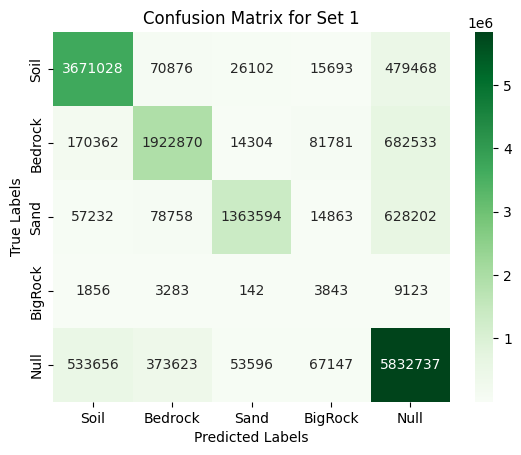

In [67]:
y_pred = model.predict(X_test1)
y_test12 = y_test1.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test12, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 1")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Test set 2

11/11 [==============================] - 0s 30ms/step


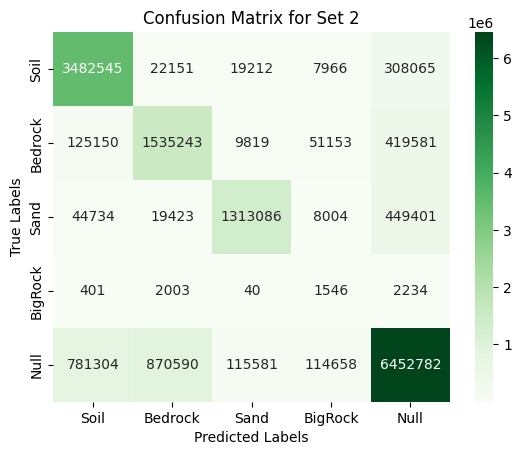

In [68]:
y_pred = model.predict(X_test2)
y_test22 = y_test2.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test22, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 2")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Test Set 3

11/11 [==============================] - 0s 29ms/step


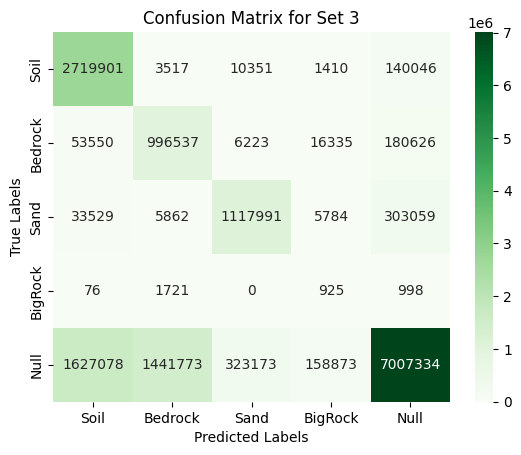

In [69]:
y_pred = model.predict(X_test3)
y_test32 = y_test3.reshape(-1)

predicted_classes = np.argmax(y_pred, axis=-1)

predicted_classes = predicted_classes.reshape(-1)

cm = confusion_matrix(y_test32, predicted_classes, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Set 3")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Graphical Representations

Prediction Output Segmentation Images

11/11 [==============================] - 0s 29ms/step


<ipython-input-70-c1b0c6fd0c37>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)


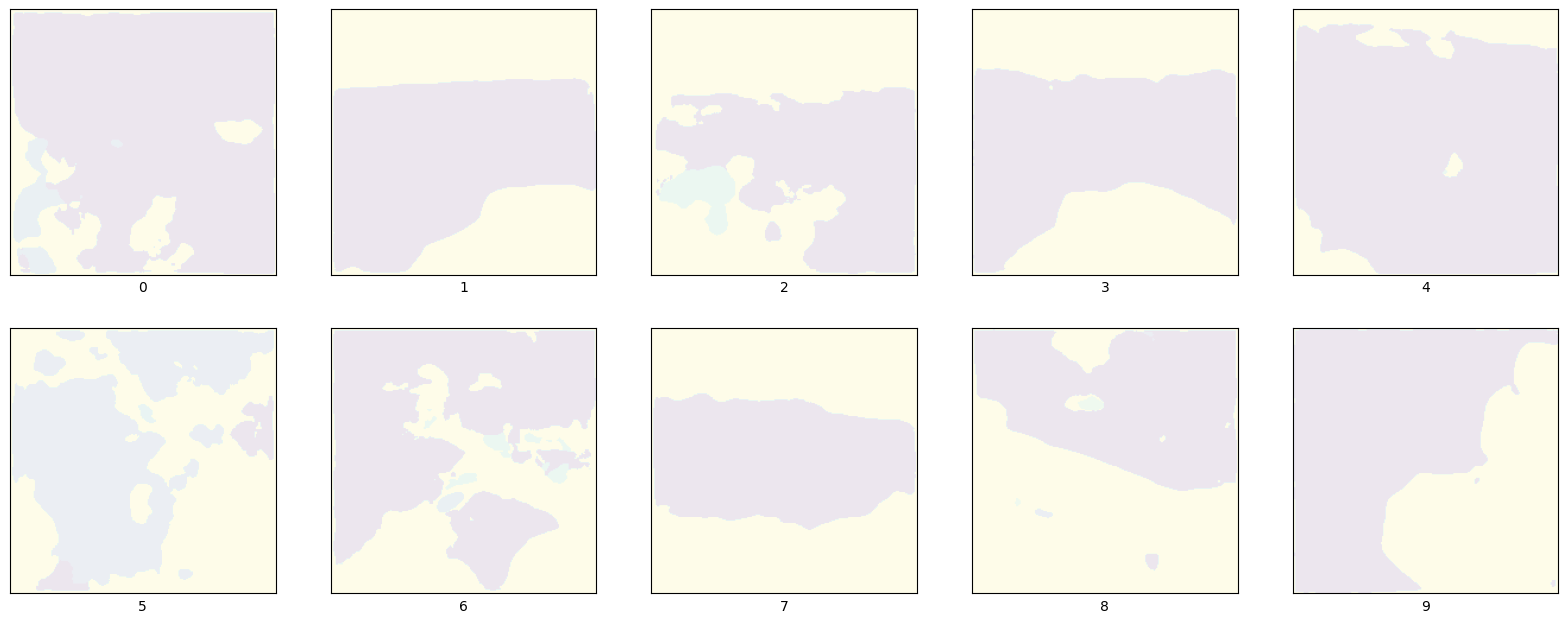

In [70]:
y_pred = model.predict(X_test1)
predicted_classes = np.argmax(y_pred, axis=-1)

plt.figure(figsize=(20,20))
plt.title("Prediction Output Segmentation")
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predicted_classes[i], alpha = 0.1)
    plt.xlabel(i)
plt.show()

Real Output Segmentation Images

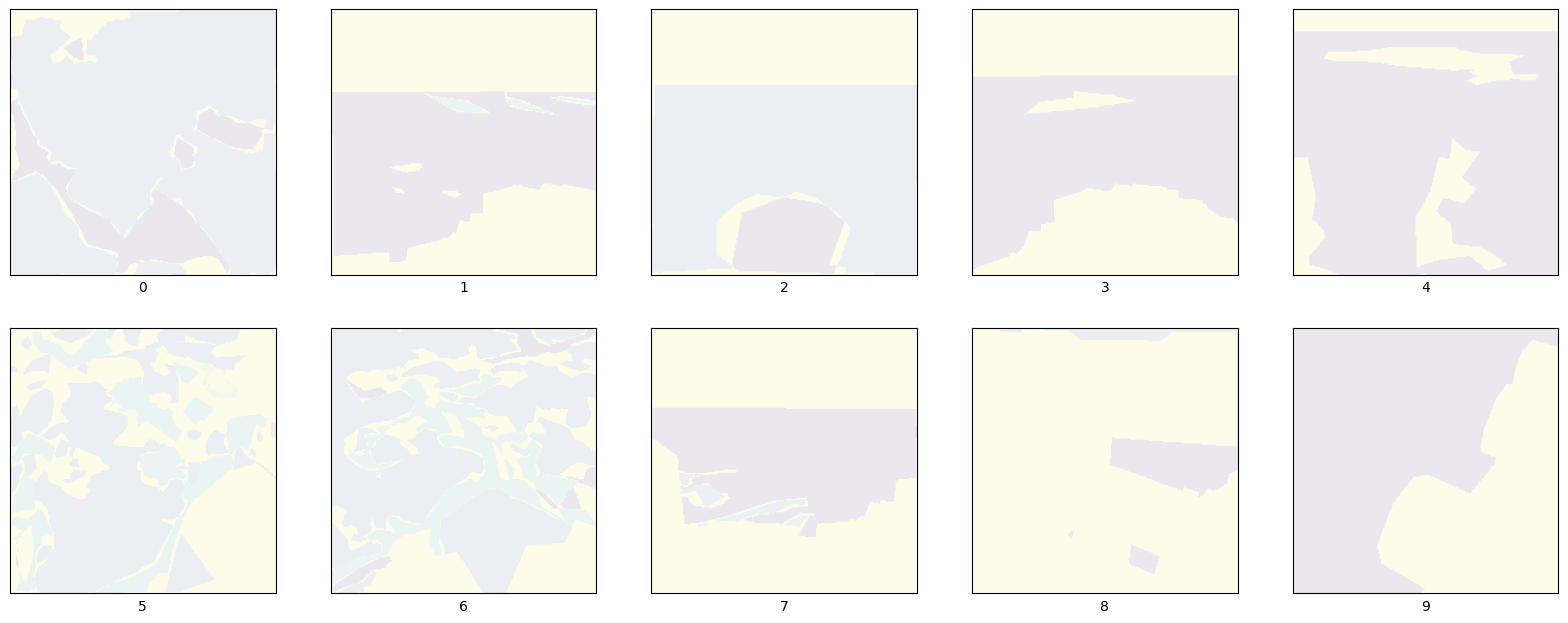

In [71]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(y_test1[i], alpha = 0.1)
    plt.xlabel(i)
    
plt.show()